In [ ]:
# Mixed Data t

from google.colab import files
uploaded = files.upload()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded["LoanPreprocessed.csv"]))
print(df)

target = 'loan_status'
class_distribution = df[target].value_counts()
print(class_distribution)

attributes_list = [col for col in df.columns]
attributes_list = attributes_list[:-1]

Saving LoanPreprocessed.csv to LoanPreprocessed.csv
      person_age  person_gender  person_education  person_income  \
0       0.056452              0              0.75       0.007212   
1       0.032258              1              0.00       0.008052   
2       0.056452              1              0.25       0.006998   
3       0.008065              1              0.75       0.006021   
4       0.088710              1              0.25       0.024018   
...          ...            ...               ...            ...   
8995    0.072581              0              0.50       0.015347   
8996    0.048387              0              0.00       0.006347   
8997    0.040323              0              0.00       0.004920   
8998    0.056452              0              0.00       0.010202   
8999    0.177419              1              0.00       0.005040   

      person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0              0.000                  RENT   0.101449  

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

attributes = df.drop(columns=[target])
#print(attributes)

class_labels = df[target]
#print(class_labels)

a_train, a_test, c_train, c_test = train_test_split(attributes, class_labels, test_size=0.2, random_state=42)
print(a_test)
print(c_train.value_counts())
print(c_test.value_counts())

      person_age  person_gender  person_education  person_income  \
7940    0.024194              0              0.25       0.016876   
1162    0.048387              1              0.00       0.010642   
582     0.032258              0              0.00       0.006394   
4081    0.016129              1              0.00       0.006490   
8412    0.088710              1              0.50       0.010203   
...          ...            ...               ...            ...   
3063    0.056452              0              1.00       0.003223   
6925    0.032258              0              0.50       0.005864   
6521    0.072581              1              0.00       0.010715   
3002    0.024194              1              0.25       0.007375   
1298    0.129032              1              0.25       0.012017   

      person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
7940           0.008              MORTGAGE   0.688406          EDUCATION   
1162           0.032           

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

k = 85 # num of neighbors
predictions = []

# test accuracy
for test_case in a_test.to_numpy():
  dists = []
  for i, train_case in enumerate(a_train.to_numpy()):
    dist = 0
    for j in range(len(attributes_list)):
      if type(train_case[j]) == str:
        if test_case[j] != train_case[j]:
          dist += 1
      else:
        dist += (test_case[j] - train_case[j]) ** 2
    dists.append((np.sqrt(dist), c_train.iloc[i]))
  dists = sorted(dists, key=lambda x:x[0]) # sort least distance to highest
  k_neighbors = dists[:k]
  k_labels = [n[1] for n in k_neighbors]

  label_counts = {}
  for l in k_labels:
    if l not in label_counts:
      label_counts[l] = 0
    label_counts[l] += 1
  majority = max(label_counts, key=label_counts.get)
  predictions.append(majority)

accuracy = accuracy_score(c_test, predictions)
print(f"test accuracy: {accuracy:.4%}")


test accuracy: 86.2778%


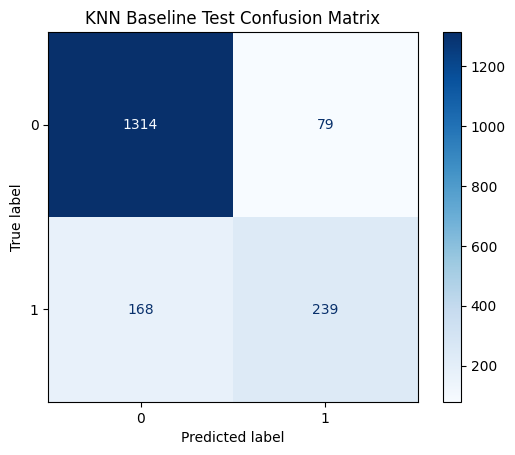

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(c_test, predictions, labels=df[target].unique())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[target].unique())
display.plot(cmap=plt.cm.Blues)
plt.title("KNN Baseline Test Confusion Matrix")
plt.show()

In [ ]:
# improved mix type KNN with mahalobis
import numpy as np
from sklearn.metrics import accuracy_score

k = 85 # num of neighbors
predictions = []

# precompute inverse matrix
numeric_f = a_train.select_dtypes(include=['float', 'int']).columns
idxs = [a_train.columns.get_loc(col) for col in numeric_f]

cov_matrix = np.cov(a_train[numeric_f].to_numpy(), rowvar=False)
inv_cov = np.linalg.inv(cov_matrix)

# test accuracy
for test_case in a_test.to_numpy():
  dists = []
  for i, train_case in enumerate(a_train.to_numpy()):
    dist = 0
    diff = test_case[idxs] - train_case[idxs]
    mahalanobis_dist = np.dot(np.dot(diff, inv_cov), diff.T)  # Vector operation

    dist += mahalanobis_dist

    for j in range(len(attributes_list)):
      if type(train_case[j]) == str:
        if test_case[j] != train_case[j]:
          dist += 60

    dists.append((np.sqrt(dist), c_train.iloc[i]))
  dists = sorted(dists, key=lambda x:x[0]) # sort least distance to highest
  k_neighbors = dists[:k]
  k_labels = [n[1] for n in k_neighbors]

  label_counts = {}
  for l in k_labels:
    if l not in label_counts:
      label_counts[l] = 0
    label_counts[l] += 1
  majority = max(label_counts, key=label_counts.get)
  predictions.append(majority)


accuracy = accuracy_score(c_test, predictions)
print(f"test accuracy: {accuracy:.4%}")


test accuracy: 86.2222%


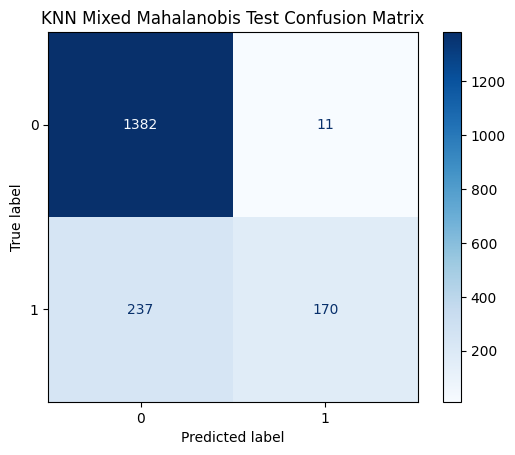

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(c_test, predictions, labels=df[target].unique())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[target].unique())
display.plot(cmap=plt.cm.Blues)
plt.title("KNN Mixed Mahalanobis Test Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter

c_counts = Counter(c_train)

major = max(c_counts, key=c_counts.get)
minor = min(c_counts, key=c_counts.get)

weights = {}
for label, count in c_counts.items():
    if label == minor:
        weights[label] = 2.0
    else:
        weights[label] = 1.0

print("Class Weights:", weights)

Class Weights: {0: 1.0, 1: 2.0}


In [ ]:
# improved mix type KNN with mahalobis and minority class weighting
import numpy as np
from sklearn.metrics import accuracy_score

k = 96 # larger k works better here
predictions = []

# precompute inverse matrix
numeric_f = a_train.select_dtypes(include=['float', 'int']).columns
idxs = [a_train.columns.get_loc(col) for col in numeric_f]

cov_matrix = np.cov(a_train[numeric_f].to_numpy(), rowvar=False)
inv_cov = np.linalg.inv(cov_matrix)

# test accuracy
for test_case in a_test.to_numpy():
  dists = []
  for i, train_case in enumerate(a_train.to_numpy()):
    dist = 0
    diff = test_case[idxs] - train_case[idxs]
    mahalanobis_dist = np.dot(np.dot(diff, inv_cov), diff.T)  # Vector operation

    dist += mahalanobis_dist

    for j in range(len(attributes_list)):
      if type(train_case[j]) == str:
        if test_case[j] != train_case[j]:
          dist += 60

    dists.append((np.sqrt(dist), c_train.iloc[i]))
  dists = sorted(dists, key=lambda x:x[0]) # sort least distance to highest
  k_neighbors = dists[:k]
  k_labels = [n[1] for n in k_neighbors]

  label_counts = {}
  for neighbor_dist, neighbor_label in k_neighbors:
    weight = weights[neighbor_label]
    label_counts[neighbor_label] = label_counts.get(neighbor_label, 0) + weight

  majority_label = max(label_counts, key=label_counts.get)
  predictions.append(majority_label)

accuracy = accuracy_score(c_test, predictions)
print(f"test accuracy: {accuracy:.4%}")

test accuracy: 88.9444%


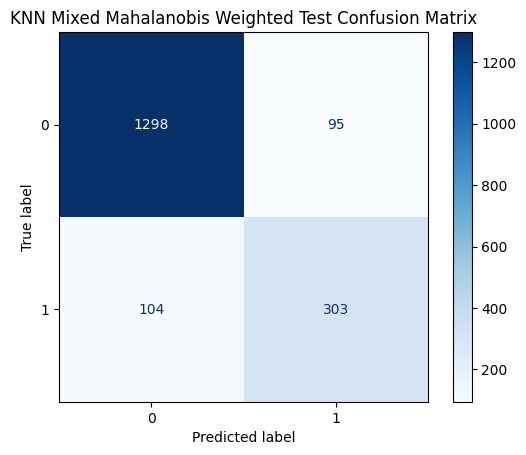

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(c_test, predictions, labels=df[target].unique())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[target].unique())
display.plot(cmap=plt.cm.Blues)
plt.title("KNN Mixed Mahalanobis Weighted Test Confusion Matrix")
plt.show()

In [ ]:
# minority class weighting for classic euclidean distance
import numpy as np
from sklearn.metrics import accuracy_score

k = 85 # num of neighbors
predictions = []

# test accuracy
for test_case in a_test.to_numpy():
  dists = []
  for i, train_case in enumerate(a_train.to_numpy()):
    dist = 0
    for j in range(len(attributes_list)):
      if type(train_case[j]) == str:
        if test_case[j] != train_case[j]:
          dist += 1
      else:
        dist += (test_case[j] - train_case[j]) ** 2
    dists.append((np.sqrt(dist), c_train.iloc[i]))
  dists = sorted(dists, key=lambda x:x[0]) # sort least distance to highest
  k_neighbors = dists[:k]
  k_labels = [n[1] for n in k_neighbors]

  label_counts = {}
  for neighbor_dist, neighbor_label in k_neighbors:
    weight = weights[neighbor_label]
    label_counts[neighbor_label] = label_counts.get(neighbor_label, 0) + weight

  majority_label = max(label_counts, key=label_counts.get)
  predictions.append(majority_label)

accuracy = accuracy_score(c_test, predictions)
print(f"test accuracy: {accuracy:.4%}")

test accuracy: 82.7222%


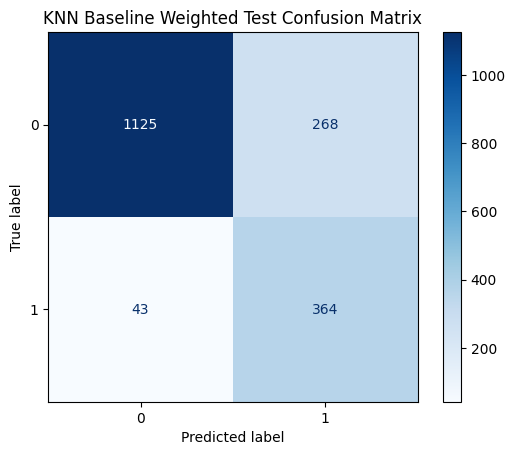

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(c_test, predictions, labels=df[target].unique())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[target].unique())
display.plot(cmap=plt.cm.Blues)
plt.title("KNN Baseline Weighted Test Confusion Matrix")
plt.show()